In [1]:
# 加载常用包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# 加载数据
train=pd.read_csv(r'./data/train.csv',parse_dates=['date'])
test=pd.read_csv(r'./data/test.csv',parse_dates=['date'])
submission=pd.read_csv(r'./data/sample_submit.csv')

print('train:',train.shape)
print('test:',test.shape)
print('submission:',submission.shape)
train.head()

train: (2253, 4)
test: (152, 2)
submission: (152, 3)


,id,date,questions,answers
0,1,2010-10-01,742,1561
1,2,2010-10-02,400,783
2,3,2010-10-03,388,771
3,4,2010-10-04,762,1474
4,5,2010-10-05,821,1639


Text(0.5, 1.0, '2011 questions&answer trend')

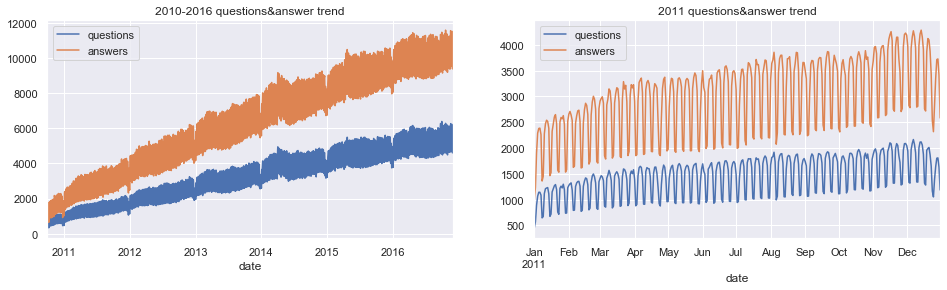

In [14]:
# 时间序列
%matplotlib inline
fig,axes=plt.subplots(1,2,figsize=(16,4))
train.iloc[:,1:].set_index("date").plot(ax=axes[0])
axes[0].set_title("2010-2016 questions&answer trend")
train[(train["date"]>='2011-01-01')&(train["date"]<='2011-12-31')].iloc[:,1:].set_index("date").plot(ax=axes[1])
axes[1].set_title("2011 questions&answer trend")

从时序图来看，新增问题数量和回答数量都逐渐上升，存在长期趋势，此外通过观察某一年的每一天的新增问答数可以看出，存在很强的周期性，简单来看一个月有4个周期。

In [15]:
# 查看缺失值
train.isnull().sum()

id           0
date         0
questions    0
answers      0
dtype: int64

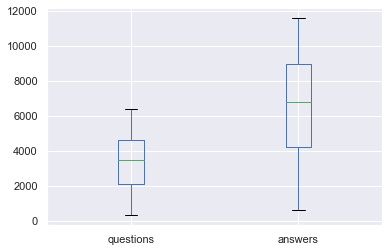

In [16]:
# 查看箱型图
train[["questions","answers"]].boxplot()
# 数据较未正常，无需进行数据预处理

## 特征工程

**美国节假日规则**
* 1月1日：元旦
* 1月的第三个星期一：马丁·路德·金纪念日
* 2月的第三个星期一：总统节
* 5月的最后一个星期一：阵亡将士纪念日
* 7月4日：美国国庆
* 9月的第一个星期一：劳动节
* 11月的第四个星期四：感恩节
* 12月25日：圣诞节

In [3]:
# 构造节假日函数
def WeekToDay(y,m,c,w,B):
    '''输入哪年哪月第几个星期几，以及正数还是倒数，输出几号'''
    B=bool(B)
    if m==1 or m==2:
        m+=12
        y-=1
    i=0
    d=1 if B else 31
    for j in range(31):
        week = round((d + 2*m+3*(m+1)/5+y+y/4-y/100+y/400)%7)
        week = 7 if week==0 else week
        if week==w:
            i+=1
        if i==c:
            break
        if B:
            d+=1
        else:
            d-=1
    if d<10:
        d='0%d'%d
    return str(d)

def get_holiday(year):
    '''获取y年份的节假日.'''
    holiday=[]
    for y in year:
        holiday.append('%d-01-01'%y)  # 元旦
        holiday.append("%d-01-%s"%(y,WeekToDay(y,1,3,1,1)))  
        holiday.append('%d-02-%s'%(y,WeekToDay(y,2,3,1,1))) 
        holiday.append('%d-05-%s'%(y,WeekToDay(y,5,1,1,0)))  # 倒数
        holiday.append('%d-07-04'%y)  
        holiday.append('%d-09-%s'%(y,WeekToDay(y,9,1,1,1)))  
        holiday.append('%d-11-%s'%(y,WeekToDay(y,11,4,4,1)))
        holiday.append('%d-12-25'%y)
    return holiday

holiday=get_holiday(range(2010,2019))

In [28]:
# 设置字段
# 年，月，日，周，季度，工作日，节假日
from sklearn.base import BaseEstimator,TransformerMixin

date_ix=0   # 日期所在列索引

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    
    def __init__(self,date_ix,holiday=None):
        self.date_ix=date_ix
        self.holiday=holiday
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        # 年
        year = [pd.to_datetime(i).year for i in X[:,self.date_ix]]         # 年份
        
        def cal_season(m):
            '''判断季度'''
            return m//3 if m%3==0 else m//3+1
    
        month = [pd.to_datetime(i).month for i in X[:,self.date_ix]]       # 月份
        season = [cal_season(i) for i in month] # 季度
        # month = pd.get_dummies(month)       # 月份
        day = [pd.to_datetime(i).day for i in X[:,self.date_ix]]           # 月份
        week = [pd.to_datetime(i).week for i in X[:,self.date_ix]]         # 周
        dayofweek = pd.get_dummies([pd.to_datetime(i).dayofweek for i in X[:,self.date_ix]])     # 星期几
        def cal_daymonth(d):
            '''将每个月的日期按7,14,21分成4段'''
            return d//7 if d%7==0 else d//7+1
        
        dayofmonth = pd.get_dummies([cal_daymonth(i) for i in day])# 一周划分为4个部分
        if self.holiday is None:
            return np.c_[year,month,season,day,week,dayofweek]
        else:
            holiday = [1 if str(pd.to_datetime(i)) in self.holiday else 0 for i in X[:,self.date_ix]]
        # 全连接
            return np.c_[year,month,season,day,week,dayofweek,holiday]

In [5]:
# 数据划分
from sklearn.model_selection import train_test_split

X = train["date"].values[:,np.newaxis]
Y1= train["questions"].values
Y2= train["answers"].values

Xtrain,Xtest,y1train,y1test=train_test_split(X,Y1,random_state=42)
Xtrain,Xtest,y2train,y2test=train_test_split(X,Y2,random_state=42)

In [29]:
# 建立模型
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 添加变量的转换器
attr_adder=CombinedAttributesAdder(date_ix=0,holiday=holiday)

In [30]:
from sklearn.base import clone
def main(rg_name="lng",rg_model=LinearRegression()):
    model = Pipeline([
        ('attr_adder',attr_adder),
        ('std_scaler',StandardScaler()),
        (rg_name,rg_model)
    ])

    # questions
    model.fit(Xtrain,y1train)
    model_q=clone(model)               # question1
    pred1=model.predict(Xtest)
    # answers
    model.fit(Xtrain,y2train)
    model_a=clone(model)               # question1
    pred2=model.predict(Xtest)

#     print(pred1[:10])
#     print(pred2[:10])
    # 查看错误率
    def mape(ptest,pred):
        return np.mean(abs(ptest-pred)/ptest)

    mape1=mape(y1test,pred1)
    mape2=mape(y2test,pred2)
    mape3=(mape1+mape2)/2
    print("Questions Mape:",mape1)
    print("Answers Mape:",mape2)
    print("Final Mape:",mape3)
    return model_q,model_a

model_q,model_a=main()

Questions Mape: 0.08215884632240986
Answers Mape: 0.05587510009328042
Final Mape: 0.06901697320784514


In [31]:
# 决策树模型
from sklearn.tree import DecisionTreeRegressor

dr_model=main('dtr',DecisionTreeRegressor())

Questions Mape: 0.03303900087115166
Answers Mape: 0.02935908982788905
Final Mape: 0.031199045349520352


In [32]:
# 预测实际结果
questions=dr_model[0].fit(Xtrain,y1train).predict(test["date"].values[:,np.newaxis])
answers=dr_model[1].fit(Xtrain,y2train).predict(test["date"].values[:,np.newaxis])

print(questions[:10])
print(answers[:10])

[5649. 5575. 4706. 4692. 6020. 6124. 6128. 6128. 5575. 4706.]
[10636. 11079.  9547.  9397. 11066. 11270. 10816. 11270. 11079.  9547.]


In [34]:
submission["questions"]=questions
submission["answers"]=answers

submission.head()

,id,questions,answers
0,2254,5649.0,10636.0
1,2255,5575.0,11079.0
2,2256,4706.0,9547.0
3,2257,4692.0,9397.0
4,2258,6020.0,11066.0


In [197]:
submission.to_csv("my_result.csv")

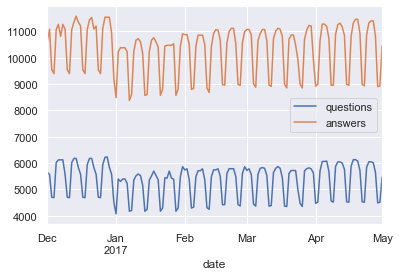

In [35]:
test.drop('id',axis=1).join(submission.drop('id',axis=1)).set_index('date').plot()